In [1]:
from experiment import experiment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import datetime

data_vault = {}

In [2]:
def run_trials(params,trials,day_metric = 0, counts = False):
    assert day_metric in (0,1)
    models =['naive_sentiments', 'logistic_regression','deep_learning','transformer']
    trial_data = {m: [] for m in models}
    vault = []
    state_seeds = [10,42,73,103,172,95,70,27,559,360]
    state_seeds = state_seeds[:trials]
    lengths = []
    for i in (state_seeds):
        params['random_state_int'] = i
        data = experiment(**params)
        vault.append(data)
        lengths.append(len(data['defend_labels']))
        for m in models:
            if m not in trial_data.keys():
                trial_data[m] = []
            model_labels = np.array(data[m])
            model_conf = np.array(data[m+'_conf'])
            model_day_label = model_conf**day_metric*model_labels
            trial_data[m].append(np.average(model_day_label))
    if counts:
        return trial_data, lengths, vault
    return trial_data, vault
def run_experiments(trials, samples = 100,attack_density_step = .05):
    default_params ={
    'samples':samples,'train_samples':4*samples,'random_state_int':42, 'split' :[.5,.5],
               'Attack_Status' :False,'Attack_Direction' :'Neg', 'attack_density' :.1,
               'Defend_Status' :False, 'defense_tolerance' :.4}
    print('Running Baseline Trial')
    baseline,baseline_raw_data = run_trials(default_params, trials=trials)
    data_vault['baseline'] = baseline_raw_data
    attack_densities = np.arange(0,1,attack_density_step)
    default_params['Attack_Status'] = True
    attacked = []
    for d in tqdm(attack_densities):
        default_params['attack_density'] = d
        attack_nodef, attack_nodef_raw = run_trials(default_params, trials = trials)
        attacked.append(attack_nodef)
        data_vault['attack_no_def_'+str(d)] = attack_nodef_raw 
    default_params['Defend_Status'] = True
    defended = []
    for d in tqdm(attack_densities):
        default_params['attack_density'] = d
        attack_wdef, attack_wdef_raw = run_trials(default_params, trials = trials)
        defended.append(attack_wdef)
        data_vault['attack_w_def_'+str(d)] = attack_wdef_raw
    return baseline,attacked,defended


In [3]:
def run_defense_experiments(trials, samples = 100,def_tol_step = .05):
    default_params ={
    'samples':samples,'train_samples':4*samples,'random_state_int':42, 'split' :[.5,.5],
               'Attack_Status' :False,'Attack_Direction' :'Neg', 'attack_density' :.4,
               'Defend_Status' :True, 'defense_tolerance' :.4}
    print('Running Baseline Trial')
    baseline, lengths, baseline_raw = run_trials(default_params, trials=trials, counts = True)
    data_vault['var_conf_base'] = baseline_raw
    def_tols = np.arange(0,1,def_tol_step)
    default_params['Attack_Status'] = True
    default_params['Defend_Status'] = True
    defended = []
    lengths = []
    for d in tqdm(def_tols):
        default_params['defense_tolerance'] = d
        trial_data, l, var_conf_raw = run_trials(default_params, trials = trials, counts = True)
        defended.append(trial_data)
        lengths.append(l)
        data_vault['var_conf_'+str(d)] = var_conf_raw
    return baseline,defended, lengths


In [4]:
def to_dataframe(data,x_step):
    '''
    data structure
    list of dictinaries
    attack_density -> {model : [list of values]}
    '''
    models =['naive_sentiments', 'deep_learning','transformer']
    output = pd.DataFrame({},index = models)
    attack_densities = np.arange(0,1,x_step)
    for i in range(len(attack_densities)):
        values = [np.average(data[i][m]) for m in models]
        output[attack_densities[i]] = values
    return output
def graph_df(df):
    plt.figure()
    df.T.plot(marker='o')
    plt.xlabel('Density')
    plt.ylabel('Score')
    plt.title('Model Performance by Density')
    plt.grid(True)  
    plt.legend(title='Model')
    plt.show()


In [ ]:
step = .05
baseline_data, attacked_data, defended_data = run_experiments(trials = 10, attack_density_step=step)
del baseline_data['logistic_regression']

Running Baseline Trial


 80%|████████  | 16/20 [30:32<08:26, 126.68s/it]

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
naive_sentiments,-0.176,-0.190476,-0.205455,-0.212174,-0.213333,-0.2096,-0.210769,-0.213333,-0.222857,-0.234483,-0.234667,-0.238710,-0.23625,-0.231515,-0.241176,-0.251429,-0.248889,-0.254054,-0.258947,-0.264615
deep_learning,-0.234,-0.255238,-0.276364,-0.293913,-0.310000,-0.3248,-0.343077,-0.354074,-0.374286,-0.390345,-0.396000,-0.407742,-0.41875,-0.426667,-0.440000,-0.445714,-0.455556,-0.463784,-0.470526,-0.475897
transformer,-0.730,-0.727619,-0.725455,-0.725217,-0.723333,-0.7248,-0.726154,-0.720000,-0.718571,-0.722759,-0.717333,-0.717419,-0.72375,-0.724848,-0.725882,-0.723429,-0.723333,-0.718919,-0.717895,-0.718974


<Figure size 640x480 with 0 Axes>

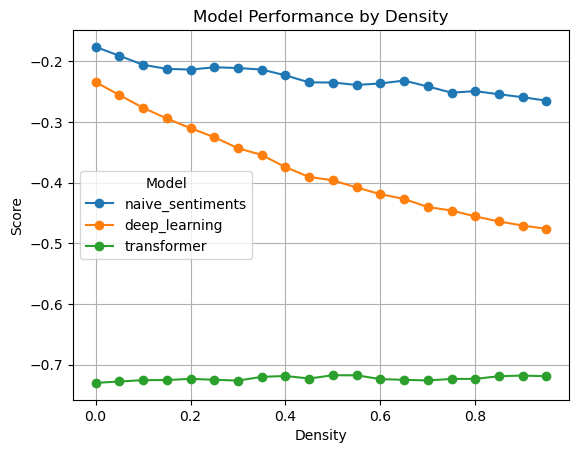

In [ ]:
attacked_data_df = to_dataframe(attacked_data,step)
display(attacked_data_df)
graph_df(attacked_data_df)

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
naive_sentiments,-0.137269,-0.155047,-0.177479,-0.191289,-0.201947,-0.204415,-0.207398,-0.214568,-0.225780,-0.234246,-0.234023,-0.236092,-0.231873,-0.225718,-0.235996,-0.246871,-0.242351,-0.249946,-0.256430,-0.261324
deep_learning,-0.289650,-0.311011,-0.334763,-0.353384,-0.370391,-0.385988,-0.406898,-0.421972,-0.441220,-0.454679,-0.456726,-0.468484,-0.481192,-0.487792,-0.499080,-0.501033,-0.509502,-0.517491,-0.521949,-0.522601
transformer,-0.754911,-0.758674,-0.764421,-0.767687,-0.763729,-0.767065,-0.774322,-0.773517,-0.777541,-0.783379,-0.779591,-0.781898,-0.788811,-0.789308,-0.793729,-0.787229,-0.783931,-0.782270,-0.781734,-0.779754


<Figure size 640x480 with 0 Axes>

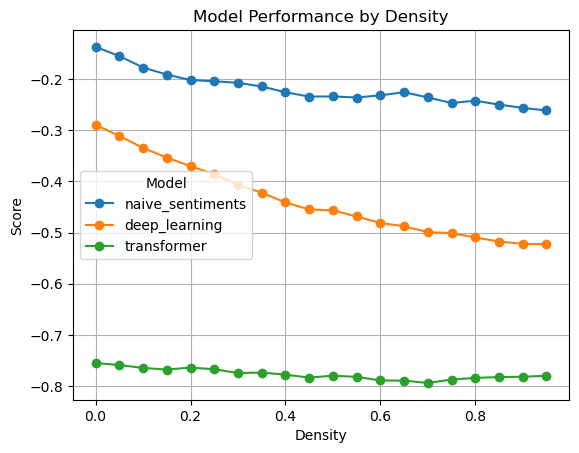

In [ ]:
defended_data_df = to_dataframe(defended_data,step)
display(defended_data_df)
graph_df(defended_data_df)

In [ ]:
def_trial_base,def_trials_data, lengths_lst = run_defense_experiments(trials = 10, def_tol_step=step)
del def_trial_base['logistic_regression']


Running Baseline Trial


100%|██████████| 20/20 [44:02<00:00, 132.13s/it]


In [ ]:
now = str(datetime.datetime.now())

filename = now+"_raw_data.pkl"
with open(filename, 'wb') as file:
    pickle.dump(data_vault, file)

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
naive_sentiments,-0.137269,-0.155047,-0.177479,-0.191289,-0.201947,-0.204415,-0.207398,-0.214568,-0.225780,-0.234246,-0.234023,-0.236092,-0.231873,-0.225718,-0.235996,-0.246871,-0.242351,-0.249946,-0.256430,-0.261324
deep_learning,-0.289650,-0.311011,-0.334763,-0.353384,-0.370391,-0.385988,-0.406898,-0.421972,-0.441220,-0.454679,-0.456726,-0.468484,-0.481192,-0.487792,-0.499080,-0.501033,-0.509502,-0.517491,-0.521949,-0.522601
transformer,-0.754911,-0.758674,-0.764421,-0.767687,-0.763729,-0.767065,-0.774322,-0.773517,-0.777541,-0.783379,-0.779591,-0.781898,-0.788811,-0.789308,-0.793729,-0.787229,-0.783931,-0.782270,-0.781734,-0.779754


<Figure size 640x480 with 0 Axes>

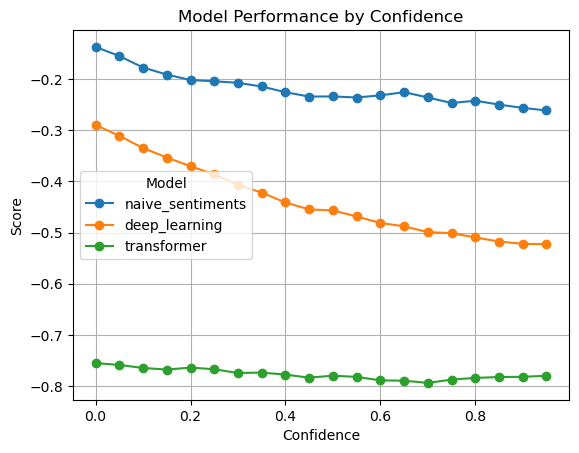

In [ ]:
def_trials_df = to_dataframe(def_trials_data,step)
display(defended_data_df)
def graph_vardef_df(df):
    plt.figure()
    df.T.plot(marker='o')
    plt.xlabel('Confidence')
    plt.ylabel('Score')
    plt.title('Model Performance by Confidence')
    plt.grid(True)  
    plt.legend(title='Model')
    plt.show()
graph_vardef_df(defended_data_df)

Text(0.5, 1.0, 'Tweet Count by Confidence Tolerance')

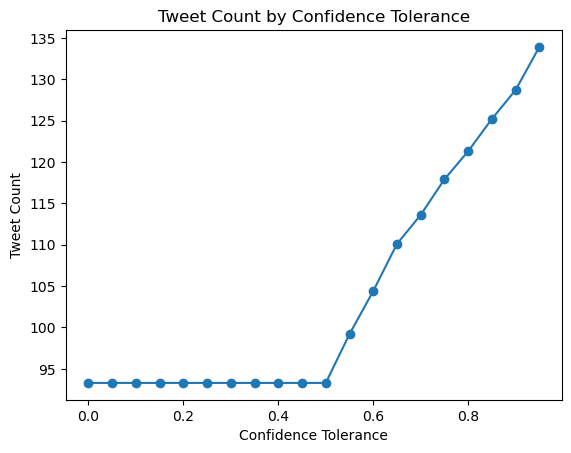

In [ ]:
plt.plot(np.arange(0,1,.05),[np.average(x) for x in lengths_lst], marker = 'o')
plt.ylabel('Tweet Count')
plt.xlabel('Confidence Tolerance')
plt.title('Tweet Count by Confidence Tolerance')

In [ ]:
def add_base_to_df(base,df):
    lst = []
    for key in base.keys():
        lst.append(np.average(base[key]))
    display(type(df))
    df.insert(0,'Base',lst)
    return df

In [ ]:

print(add_base_to_df(def_trial_base, def_trials_df).round(4).to_latex())


pandas.core.frame.DataFrame

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & Base & 0.000000 & 0.050000 & 0.100000 & 0.150000 & 0.200000 & 0.250000 & 0.300000 & 0.350000 & 0.400000 & 0.450000 & 0.500000 & 0.550000 & 0.600000 & 0.650000 & 0.700000 & 0.750000 & 0.800000 & 0.850000 & 0.900000 & 0.950000 \\
\midrule
naive_sentiments & -0.137300 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.225800 & -0.233700 & -0.229200 & -0.221500 & -0.227100 & -0.225000 & -0.226400 & -0.229000 & -0.235500 & -0.227600 \\
deep_learning & -0.289600 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.441200 & -0.442000 & -0.423600 & -0.418100 & -0.424300 & -0.414700 & -0.414400 & -0.408700 & -0.403400 & -0.388100 \\
transformer & -0.754900 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.777500 & -0.780600 & 

<Figure size 640x480 with 0 Axes>

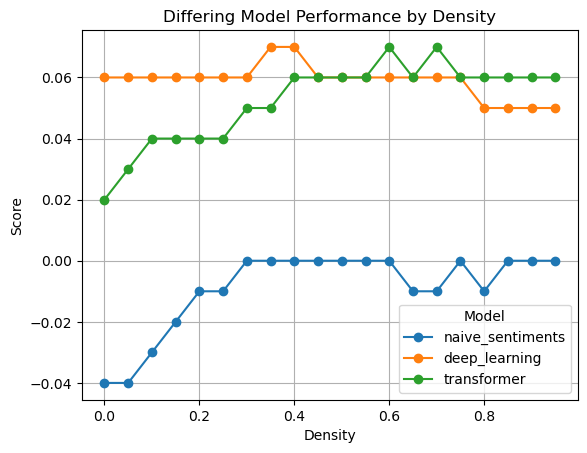

In [ ]:
plt.figure()
diff_df = attacked_data_df.subtract(defended_data_df)
diff_df.columns = [round(c,2) if isinstance(c, float) else c
                   for c in diff_df.columns]
diff_df.T.round(2).plot(marker = 'o')
plt.xlabel('Density')
plt.ylabel('Score')
plt.title('Differing Model Performance by Density')
plt.grid(True)
plt.legend(title='Model')
plt.show()

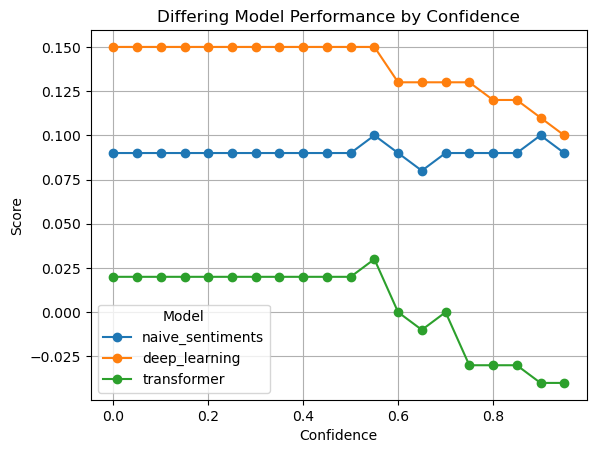

In [ ]:

col = [np.average(i) for i in def_trial_base.values()]
copy_of_df = def_trials_df.copy()
for key in copy_of_df.keys():
    copy_of_df[key] = col
copy_of_df
def_diff_df = copy_of_df - def_trials_df
def_diff_df.T.round(2).plot(marker = 'o')
plt.xlabel('Confidence')
plt.ylabel('Score')
plt.title('Differing Model Performance by Confidence')
plt.grid(True)
plt.legend(title='Model')
plt.show()